# Stratification
Julian Hsu

20-sept-2024

The purpose is to show how stratification addresses concerns that randomization does not create representative treatment samples. 


In [114]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from random import shuffle

Create functions that generate data and assignment

In [115]:
def get_data(n=None, quad=True):
    x1 = np.random.normal(0,5,n)
    y = -0.25 + 2*x1 + np.random.normal(0,2,n)  
    if quad==True:
        y += (2*x1)**2 
        y += np.sin(1+8*x1)
    else:
        pass
    return pd.DataFrame(data={'x1':x1, 'y':y})

def assign_simple(treat_number = None, data=None):
    indices = data.index.tolist()
    shuffle(indices)
    treat_indices = indices[0:treat_number]
    w_output = data.index.isin(treat_indices)
#     data['w']=0
#     data.loc[treat_indices,'w'] =  1
    return w_output

def create_strat( x_quantiles=10, data=None):
    data['x1_q'] = pd.qcut(data['x1'], q=x_quantiles, labels=np.arange(x_quantiles))
        
def assign_strat(strat_name='x1_q', treat_number=None, data=None):
#     data['w_strat']=0
    x_quantiles = len( data[strat_name].unique().tolist() )
    treat_indices_agg = []
    for q in data[strat_name].unique().tolist():
        indices = data.loc[(data[strat_name]==q)].index.tolist()
        shuffle(indices)
        treat_indices = indices[0: int(treat_number/x_quantiles)]
        treat_indices_agg.append(treat_indices)
#         data.loc[treat_indices,'w_strat'] =  1
    treat_indices_agg_mega_list = [item for sublist in treat_indices_agg for item in sublist]
    w_output = data.index.isin(treat_indices_agg_mega_list)
    return w_output

In [116]:
print('Test functions')
df = get_data(n=100)
df['w']=assign_simple(treat_number=50, data=df)
print( df['w'].mean() ) 
create_strat(x_quantiles=10, data=df)
df['w_strat']=assign_strat(strat_name='x1_q', treat_number =50, data=df)
print( df[['w','w_strat']].mean() ) 

Test functions
0.5
w          0.5
w_strat    0.5
dtype: float64


In [117]:
df.groupby('x1_q')[['w','w_strat']].mean()

,w,w_strat
x1_q,,
0,0.7,0.5
1,0.5,0.5
2,0.4,0.5
3,0.3,0.5
4,0.6,0.5
5,0.7,0.5
6,0.6,0.5
7,0.2,0.5
8,0.3,0.5


Write a function that assesses whether the treatment and control samples are similar. We use a t-test just comparing the mean.

In [118]:
from scipy import stats
def assess_balance(data=None, treatment_name='w'):
    diff = data.loc[data[treatment_name]==1]['x1'].mean() - data.loc[data[treatment_name]==0]['x1'].mean()
    res= stats.ttest_ind(data.loc[data[treatment_name]==1]['x1']
                   ,data.loc[data[treatment_name]==0]['x1'], equal_var=False)
    return diff, res[1]

def assess_count_instrata(data=None, strat_name='x1_q',
                         treatment_name='w'):
    ## Tell me the treatment allocation across all strata
    return data.groupby(strat_name)[treatment_name].mean()
    

Do simulations and assess how many times we need the balance test or not over whether or not we stratify. 

In [147]:
N =500
sim_number = 200
df_sim = pd.DataFrame()
t = False
df = get_data(n=N, quad=t)
create_strat(x_quantiles=5, data=df)
for s in range(sim_number):
    ## Simple randomization
    df['w']=assign_simple(treat_number= int(N/2), data=df)
    simple_res = assess_balance(data=df,treatment_name='w') + (np.sum( (assess_count_instrata(data=df, strat_name='x1_q', treatment_name='w') - 0.5 )**2),)
    df_sim = pd.concat([df_sim,
                       pd.DataFrame(index=['simple'], data=[simple_res],columns=['difference','pvalue','allocation_miss'])])
    
    ## Stratification randomization
    df['w_strat']=assign_strat(strat_name='x1_q', treat_number=int(N/2), data=df)
    strat_res = assess_balance(data=df,treatment_name='w_strat') + (np.sum( (assess_count_instrata(data=df, strat_name='x1_q', treatment_name='w_strat') - 0.5 )**2),)
    df_sim = pd.concat([df_sim,
                       pd.DataFrame(index=['strat'], data=[strat_res],columns=['difference','pvalue','allocation_miss'])  ])  
#     entry_df = pd.DataFrame(index=['simple','strat'], data={simple_res,strat_res}, columns=['difference','pvalue','allocation_miss'])
#     df_sim = pd.concat([df_sim, entry_df])
    
df_sim.reset_index(inplace=True)

In [149]:
df_sim['stat_sig'] = (df_sim['pvalue'] < 0.05).astype(float)
df_sim.groupby('index').mean()

,difference,pvalue,allocation_miss,stat_sig
index,,,,
simple,0.000451,0.457100,0.010494,0.03
strat,0.005741,0.799256,0.000000,0.00


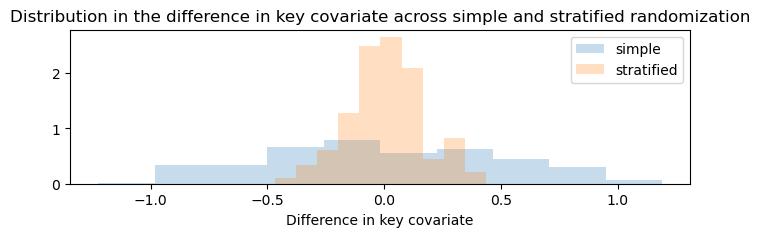

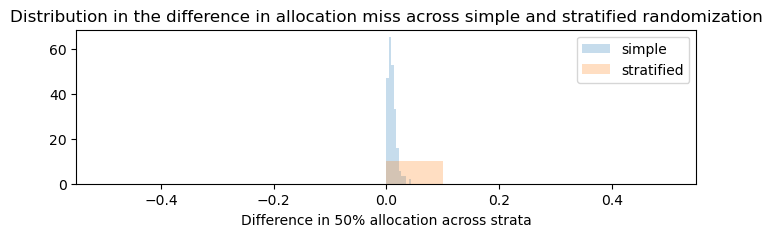

In [150]:
fig,ax = plt.subplots(figsize=(8,2))
ax.hist( df_sim.loc[df_sim['index']=='simple']['difference'],label='simple', density=True, alpha=0.25)
ax.hist( df_sim.loc[df_sim['index']=='strat']['difference'] ,label='stratified', density=True, alpha=0.25)
ax.set_xlabel('Difference in key covariate')
ax.set_title('Distribution in the difference in key covariate across simple and stratified randomization')
ax.legend()


fig,ax = plt.subplots(figsize=(8,2))
ax.hist( df_sim.loc[df_sim['index']=='simple']['allocation_miss'],label='simple', density=True, alpha=0.25)
ax.hist( df_sim.loc[df_sim['index']=='strat']['allocation_miss'] ,label='stratified', density=True, alpha=0.25)
ax.set_xlabel('Difference in 50% allocation across strata')
ax.set_title('Distribution in the difference in allocation miss across simple and stratified randomization')
ax.legend()